# Problem 2 - a sampling trick

Again we start with a worked example of a Hierarchical Bayesian Model.  Again we are going to make some data from a simple Gaussian distribution and add on some observational uncertainty.  We will make the data look like the luminosity (or absolute magnitude) of the red clump.

The distribution of the K-band Magnitufe of the red clump will be defined as:

$K_{\rm i, true} \sim \mathcal{N}(-1.61, 0.01)$.

$K_{i, {\rm obs}} \sim \mathcal{N}(K_{i, {\rm true}}, 0.05)$.

Let's set up this data.  This time we will have 1000 points instead of 500!

/home/davies/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/davies/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


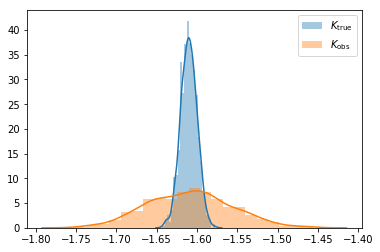

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

N = 1000
RCK = -1.61
RCS = 0.01
K_true = np.random.randn(N) * RCS + RCK
sigma_K_obs = np.ones(N) * 0.05
K_obs = K_true + np.random.randn(N) * sigma_K_obs

ax = sns.distplot(K_true, label=r'$K_{\rm true}$')
ax = sns.distplot(K_obs, label=r'$K_{\rm obs}$')
ax.legend()

It is immediately obvious, that if we were to try an estimate the spread of K-band Magnitudes for the red clump from the observed data just by measuring the standard deviation we would find an overestimate.

In [2]:
print(f'Observed data: mean = {K_obs.mean():.4f}; std = {K_obs.std(ddof=1):.4f}; ' + 
      f'error on mean = {K_obs.std(ddof=1) / N**0.5:.4f}')
print(f'True data: mean = {K_true.mean():.4f}; std = {K_true.std(ddof=1):.4f};  ' +
      f'error on mean = {K_true.std(ddof=1) / N**0.5:.4f}')

Observed data: mean = -1.6095; std = 0.0518; error on mean = 0.0016
True data: mean = -1.6101; std = 0.0100;  error on mean = 0.0003


What we want is a method that takes the observed data and estimates the spread in the true data.  I guess this can be done a number of ways but here we will look at an HBM using latent variables.  This HBM method will scale very nicely with more complex problems.

Let's jump right in a build an acyclic graph to visualise our problem:

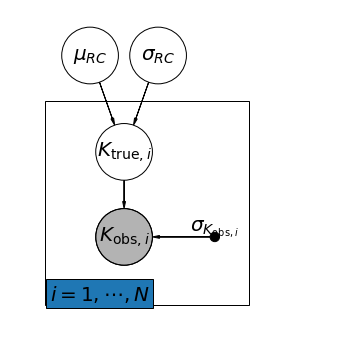

In [4]:
''' You may need to update matplotlib inorder to get this to work '''

from matplotlib import rc
rc("font", family="serif", size=20)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("mu", r"$\mu_{RC}$", 0.7, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{RC}$", 1.3, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("K_true", r"$K_{{\rm true},i}$", 1, 1.75))
# Data.
pgm.add_node(daft.Node("K_obs", r"$K_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("err", r"$\sigma_{K_{{\rm obs},i}}$", 1.8, 1.0, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("mu", "K_true")
pgm.add_edge("sigma", "K_true")
pgm.add_edge("K_true", "K_obs")
pgm.add_edge("err", "K_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.3, 0.5, 1.8, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

The red clump K-band Magnitudes are assumed to follow a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$ which are both unknowns.  Each star in $N$ has an index $i$.  Each star also has a true Magnitude, which is an unknown, and an observed Magnitude which is known with some uncertainty $\sigma_{K_{{\rm obs},i}}$.  We then treat $\mu$, $\sigma$, and $[K_{{\rm true}, 1}, K_{{\rm true}, 2}, ..., K_{{\rm true}, N}]$ as parameters that are to be estimated.  

We have the following constraints:

$K_{\rm true} \sim \mathcal{N}(K_{\rm obs}, \sigma_{K_{{\rm obs}}})$.

That is, the true values of the clump K-band magnitude must be consistent with the observed values and their uncertainties.

$K_{\rm true} \sim \mathcal{N}(\mu, \sigma)$.

Which is to say, that the distribution of $K_{\rm true}$ should be consistent with a normal distribution with mean $\mu$ and standard deviation $\sigma$.

We will also add the following priors that represent our exisitng knowledge of the red clump but are designed to be weakly informative:

$\mu \sim \mathcal{N}{-1.61, 0.5}$,

and 

$\sigma \sim {\rm Lognormal}(\log(0.03), 0.5)$,

Note that this is different from last time as our prior information on $\mu$ is much weaker than before.

We can code this up in stan easily!

In [13]:
code = '''
data {
    int N;  // N stars
    real Kobs[N];
    real sigmaKobs[N];
}
parameters {
    real mu;
    real<lower = 0> sigma;
    real Ktrue[N];
}
model {
    Ktrue ~ normal(Kobs, sigmaKobs);
    Ktrue ~ normal(mu, sigma);
    mu ~ normal(-1.61, 0.5);
    sigma ~ lognormal(log(0.03), 0.5);
}

'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2878c484a9fc2b7be89f6dfc30fa0042 NOW.


The stan code is written here as a string that is passed to the StanModel object.

The code 'sm = pystan.StanModel(model_code=code)' compiles the stan model for us to call later.

We can now run the code.

In [14]:
nchains = 4
data = {'N': N,
       'Kobs': K_obs,
       'sigmaKobs': sigma_K_obs}
fit = sm.sampling(data=data, iter=1000, chains=nchains)

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


You can watch the fit proceed in the terminal window.  Running on my laptop, the fit took 5 seconds.

We can print the fit object to see lots of useful information.  Perhaps most importantly, R_hat gives a measure of convergence.  The closer R_hat is to unity the better.  Experience suggests that all R_hat's less than 1.02 should give reasonable results.

In [15]:
print(fit)

Inference for Stan model: anon_model_2878c484a9fc2b7be89f6dfc30fa0042.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          -1.61  8.9e-5 1.6e-3  -1.61  -1.61  -1.61  -1.61  -1.61    337    1.0
sigma        0.02  5.1e-4 2.5e-3   0.01   0.01   0.02   0.02   0.02     24   1.21
Ktrue[0]     -1.6  3.6e-4   0.02  -1.64  -1.61   -1.6  -1.59  -1.57   2000    1.0
Ktrue[1]    -1.61  3.5e-4   0.02  -1.65  -1.63  -1.61   -1.6  -1.58   2000    1.0
Ktrue[2]    -1.61  3.4e-4   0.02  -1.64  -1.62  -1.61   -1.6  -1.58   2000    1.0
Ktrue[3]    -1.62  3.6e-4   0.02  -1.65  -1.63  -1.62  -1.61  -1.59   2000    1.0
Ktrue[4]    -1.61  3.4e-4   0.02  -1.64  -1.62  -1.61   -1.6  -1.58   2000    1.0
Ktrue[5]    -1.61  3.6e-4   0.02  -1.64  -1.62  -1.61   -1.6  -1.58   2000    1.0
Ktrue[6]    -1.61  3.4e-4   0.02  -1.64  -1.62  -1.61   -1.6  -1.57   2000 

We can see that the sigma parameter has not yet converged.  But I have a sampling trick that should make convergence faster.  Let's try.

In [16]:
code = '''
data {
    int N;  // N stars
    real Kobs[N];
    real sigmaKobs[N];
}
parameters {
    real mu;
    real<lower = 0> sigma;
    real Ktruestd[N];
}
transformed parameters {
    real Ktrue[N];
    for (i in 1:N){
        Ktrue[i] = Ktruestd[i] * sigma + mu;
    }
}
model {
    Ktruestd ~ normal(0, 1);
    Ktrue ~ normal(Kobs, sigmaKobs);
    mu ~ normal(-1.61, 0.5);
    sigma ~ lognormal(log(0.03), 0.5);
}

'''
import pystan
sm2 = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8da6032bdcff5fc07da3a88a070880e0 NOW.


In [17]:
nchains = 4
data = {'N': N,
       'Kobs': K_obs,
       'sigmaKobs': sigma_K_obs}
fit2 = sm2.sampling(data=data, iter=1000, chains=nchains)

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


This takes longer to run than before (about 10 seconds on my laptop) but I hope will have convered better.  Let's see.

In [18]:
print(fit2)

Inference for Stan model: anon_model_8da6032bdcff5fc07da3a88a070880e0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu             -1.61  3.7e-5 1.7e-3  -1.61  -1.61  -1.61  -1.61  -1.61   2000    1.0
sigma           0.01  1.9e-4 3.3e-3 8.4e-3   0.01   0.01   0.02   0.02    311   1.01
Ktruestd[0]      0.3    0.02   0.96   -1.6  -0.35   0.29   0.94   2.26   2000    1.0
Ktruestd[1]    -0.27    0.02   0.96   -2.1  -0.92  -0.28   0.38   1.66   2000    1.0
Ktruestd[2]    -0.03    0.02   0.95  -1.89  -0.67  -0.03   0.62   1.82   2000    1.0
Ktruestd[3]    -0.43    0.02   0.95  -2.29  -1.06  -0.45   0.21   1.47   1868    1.0
Ktruestd[4]    -0.11    0.02   0.98  -2.02  -0.79  -0.11   0.56   1.88   2000    1.0
Ktruestd[5]   2.6e-3    0.02   0.95  -1.83  -0.65  -0.01   0.66   1.93   2000    1.0
Ktruestd[6]     0.23    0.02   0.96  -1.71  -0.4

Now sigma has converged noticably better.  The trick is that we made the parameters of interest into a bunch of parameters that are normally distributed around zero with standard deviation of unity.  We then make new transformed parameters by multiplying the $\mathcal{N}(0, 1)$ values by sigma and adding mu.  The $\mathcal{N}(0, 1)$ records the order of the stars within the distribution and then this order is transformed into meaningful parameters.  

You see, the order of the stars in the distribution changes little based on the mu and sigma proposed.  In the old code, to change the mean of the population you would need to change all the values Ktrue which can be difficult and this caused poor sampling.  In the new code, changing the mean of the population is as simple as changing mu - and this leads to better sampling and convegence.

We can look at the results as before:

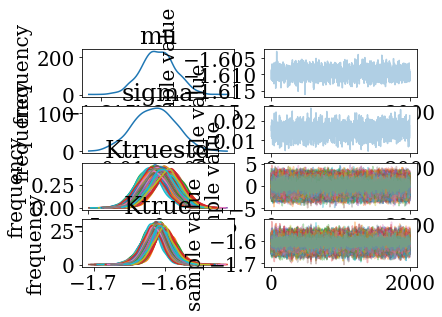

In [21]:
fit2.plot()
plt.show()

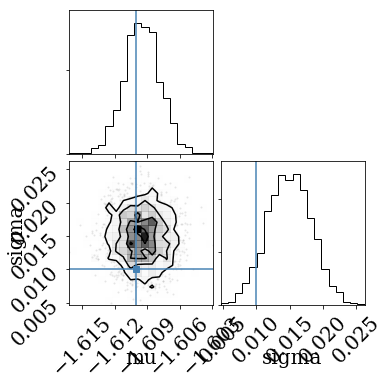

In [22]:
import corner
data = np.vstack([fit2['mu'], fit2['sigma']]).T
corner.corner(data, labels=['mu', 'sigma'], truths=[RCK, RCS])
plt.show()